# Import Libraries

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

# Loading Data

In [3]:
df = pd.read_csv('/content/in_domain_train.tsv', delimiter='\t', header= None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.sample(5)

,sentence_source,label,label_notes,sentence
1503,r-67,1,NaN,It is beans that I don't like.
466,bc01,0,*,John was unknown to be the murderer.
6355,d_98,0,*,You must pick any flower.
8320,ad03,1,NaN,What did John buy?
3443,ks08,1,NaN,Some sentences can go on and on.


In [4]:
df.shape

(8551, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8551 entries, 0 to 8550
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentence_source  8551 non-null   object
 1   label            8551 non-null   int64 
 2   label_notes      2527 non-null   object
 3   sentence         8551 non-null   object
dtypes: int64(1), object(3)
memory usage: 267.3+ KB


# Tokenize Using BERT

In [6]:
# In fist we organize data using BERT, Like adding [CLS] & [SEP]

sentences = df['sentence'].values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df['label'].values

In [7]:
sentences[:5]

["[CLS] Our friends won't buy this analysis, let alone the next one we propose. [SEP]",
 "[CLS] One more pseudo generalization and I'm giving up. [SEP]",
 "[CLS] One more pseudo generalization or I'm giving up. [SEP]",
 '[CLS] The more we study verbs, the crazier they get. [SEP]',
 '[CLS] Day by day the facts are getting murkier. [SEP]']

In [8]:
labels[:5]

array([1, 1, 1, 1, 1])

In [9]:
# we tokenize words using BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [10]:
print(tokenized_texts[0])

['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


# Padding & Splitting

In [11]:
max_padd = 128
token_number = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
token_padding = pad_sequences(token_number, maxlen= max_padd, dtype='long', padding='post', truncating='post')

In [12]:
token_padding[:2]

array([[  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,
         1010,  2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [13]:
# we need the model to focus on important words
attention_masks = []

for seq in token_padding:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

In [14]:
attention_masks[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [15]:
# split data
train_inputs, val_inputs, train_labels, val_labels = train_test_split(token_padding, labels, test_size=0.2, random_state=44, shuffle=True)
train_masks, val_masks, _, _ = train_test_split(attention_masks, token_padding, test_size=0.2, random_state=44, shuffle=True)

In [16]:
# Convert Dtype To Tensor
train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

In [17]:
# organize the data for Fine-Tuning
batch_size = 32


train_data= TensorDataset(train_inputs, train_masks, train_labels) # inputs, masks, labels = batch
train_sampler = RandomSampler(train_data) # shuffle data => this is select random samples for each epoch
train_dataloader = DataLoader(dataset= train_data, sampler= train_sampler, batch_size= batch_size) # for load data as batches
# The model take the output like this shape
# for batch in train_dataloader:
#     inputs, masks, labels = batch

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data) # ordering data and select them for each epoch
val_dataloader = DataLoader(dataset= val_data, sampler= val_sampler, batch_size= batch_size)
# The model take the output like this shape
# for batch in val_dataloader:
#     inputs, masks, labels = batch

# Load BERT Model

In [18]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2) # binary classification
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [19]:
torch.save(model, 'bert_model.pt') # save model

In [27]:
save_directory = '/content/sample_data/bert_model'
os.makedirs(save_directory, exist_ok=True)

model_path = os.path.join(save_directory, 'pytorch_model.bin')
torch.save(model.state_dict(), model_path)

In [19]:
param_optimizer = list(model.named_parameters()) # list of names model param
no_decay = ['bias', 'gamma', 'beta'] # don't change the weights in this param
optimizer_grouped_param = [
    {
        'params': [param for name_param, param in param_optimizer if not any(nd in name_param for nd in no_decay)], # this for update other params
        'weight_decay': 0.01
    },
    {
        'params': [param for name_param, param in param_optimizer if any(nd in name_param for nd in no_decay)], # this for special params
        'weight_decay': 0.0
    }
]

optimizer = BertAdam(optimizer_grouped_param, lr = 2e-5, warmup = 0.1)

In [20]:
# build func to cala accuracy in Torch
def calc_accuracy(predections, labels):
    pred = np.argmax(predections, axis=1).flatten()
    ground_truth = labels.flatten()
    # compare
    return np.sum(pred == ground_truth) / len(ground_truth)

# Fine-Tuning

In [27]:
epochs = 5
train_loss = []
calc_loss = 0
sum_samples, sum_steps = 0, 0
model.to(device)
# Training
for _ in trange(epochs, desc= 'Epoch'):
    model.train()
    # for train in each epoch
    for step, batch in enumerate(train_dataloader):
        b_inputs, b_masks, b_labels = batch # unpack data input
        b_inputs = b_inputs.to(device)
        b_masks = b_masks.to(device)
        b_labels = b_labels.to(device)
        if step == 0:
            print(f"b_inputs device: {b_inputs.device}")
            print(f"b_masks device: {b_masks.device}")
            print(f"b_labels device: {b_labels.device}")
            print(f"Model device: {next(model.parameters()).device}")
        optimizer.zero_grad() # that make sure the last gradients doesn't effect on new gradients
        # forward pass
        loss = model(b_inputs, token_type_ids=None, attention_mask=b_masks, labels=b_labels)
        train_loss.append(loss.item())
        loss.backward() # select the neurons that will take the new weights after calc
        optimizer.step() # update weights

        calc_loss += loss.item()
        sum_samples += b_inputs.size(0)
        sum_steps += 1
    print("Train loss: {}".format(calc_loss/sum_steps))

# Evaluation
    eval_accuracy, eval_loss = 0, 0
    sum_eval_steps, sum_eval_samples = 0, 0

    model.eval()
    for batch in val_dataloader:
        b_inputs, b_masks, b_labels = batch # unpack data input
        b_inputs = b_inputs.to(device)
        b_masks = b_masks.to(device)
        b_labels = b_labels.to(device)
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          logits = model(b_inputs, token_type_ids=None, attention_mask=b_masks)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = calc_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        sum_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/sum_eval_steps))



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

b_inputs device: cuda:0
b_masks device: cuda:0
b_labels device: cuda:0
Model device: cuda:0
Train loss: 0.30776017166186714


Epoch:  20%|██        | 1/5 [03:00<12:02, 180.60s/it]

Validation Accuracy: 0.8126929012345678
b_inputs device: cuda:0
b_masks device: cuda:0
b_labels device: cuda:0
Model device: cuda:0
Train loss: 0.2368786925859053


Epoch:  40%|████      | 2/5 [06:00<09:00, 180.19s/it]

Validation Accuracy: 0.8028549382716049
b_inputs device: cuda:0
b_masks device: cuda:0
b_labels device: cuda:0
Model device: cuda:0
Train loss: 0.18819312915145028


Epoch:  60%|██████    | 3/5 [09:00<05:59, 179.96s/it]

Validation Accuracy: 0.8150077160493827
b_inputs device: cuda:0
b_masks device: cuda:0
b_labels device: cuda:0
Model device: cuda:0
Train loss: 0.15623345566972238


Epoch:  80%|████████  | 4/5 [11:59<02:59, 179.80s/it]

Validation Accuracy: 0.8155092592592593
b_inputs device: cuda:0
b_masks device: cuda:0
b_labels device: cuda:0
Model device: cuda:0
Train loss: 0.13319144866224727


Epoch: 100%|██████████| 5/5 [14:59<00:00, 179.89s/it]

Validation Accuracy: 0.8155864197530863


In [44]:
torch.save(model, 'grammer_check_model.pt') # save model

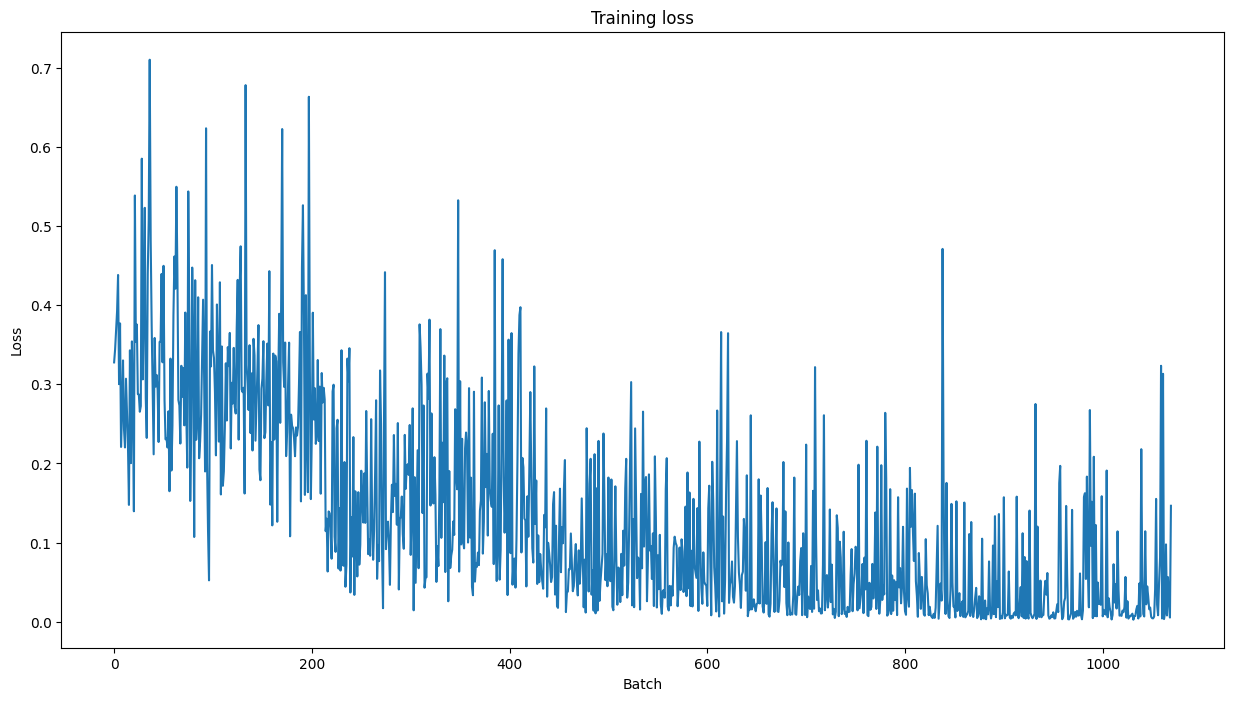

In [30]:
plt.figure(figsize=(15, 8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss)
plt.show()

# Testing

In [31]:
test_data = pd.read_csv('/content/out_of_domain_dev.tsv', delimiter='\t', header= None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
test_data.sample(5)

,sentence_source,label,label_notes,sentence
205,s_97,1,NaN,all who lost money in the scam are eligible fo...
360,swb04,0,*,chris handed bo .
364,swb04,0,*,the putter of books left .
433,w_80,1,NaN,john is sad .
132,j_71,0,*,millie will send the president an obscene tele...


In [33]:
sentences = test_data['sentence'].values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = test_data['label'].values
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [34]:
max_len = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype='long', truncating='post', padding='post')


attention_masks = []
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

In [35]:
predection_inputs = torch.tensor(input_ids)
predection_masks = torch.tensor(attention_masks)
predection_labels = torch.tensor(labels)

batch_size = 32
predection_data = TensorDataset(predection_inputs, predection_masks, predection_labels)
predection_sampler = SequentialSampler(predection_data)
predection_dataloader = DataLoader(predection_data, sampler=predection_sampler, batch_size=batch_size)

# Evaluation

In [36]:
model.eval()
predictions, true_labels = [], []

for batch in predection_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_inputs, b_masks, b_labels = batch
    with torch.no_grad():
        logits = model(b_inputs, token_type_ids=None, attention_mask=b_masks)

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

In [38]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

matthews_set

[np.float64(-0.04775182090788386),
 np.float64(-0.050964719143762556),
 np.float64(0.4857959309463206),
 np.float64(0.17338428937260214),
 np.float64(0.5222329678670935),
 np.float64(0.6147253896340708),
 np.float64(0.28941438070815306),
 np.float64(0.29277002188455997),
 np.float64(0.8320502943378436),
 np.float64(0.4700159919404217),
 np.float64(0.6042179781166439),
 np.float64(0.6666666666666666),
 np.float64(0.5807564950208268),
 np.float64(0.5897435897435898),
 np.float64(0.30261376633440124),
 np.float64(0.5222329678670935),
 0.0]

In [39]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [40]:
matthews_corrcoef(flat_true_labels, flat_predictions)


np.float64(0.4371352665723567)